In [1]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/home/tristan/LearningJAX/Flax
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25+cuda11.cudnn86
optax==0.1.8
orbax-checkpoint==0.5.0


In [2]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional

jnp.set_printoptions(precision=3, suppress=True)

# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [3]:
# WARNING: this code is from QSSM project and won't be updated 
def create_mnist_classification_dataset(bsz=128, root="./data"):
    print("[*] Generating MNIST Classification Dataset...")

    # Constants
    SEQ_LENGTH, N_CLASSES, IN_DIM = 784, 10, 1
    tf = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=0.5, std=0.5),
            transforms.Lambda(lambda x: x.view(IN_DIM, SEQ_LENGTH).t()),
        ]
    )

    train = torchvision.datasets.MNIST(
        root, train=True, download=True, transform=tf
    )
    test = torchvision.datasets.MNIST(
        root, train=False, download=True, transform=tf
    )

    def custom_collate_fn(batch):
        transposed_data = list(zip(*batch))
        labels = np.array(transposed_data[1])
        images = np.array(transposed_data[0])

        return images, labels       


    # Return data loaders, with the provided batch size
    trainloader = torch.utils.data.DataLoader(
        train, batch_size=bsz, shuffle=True, collate_fn=custom_collate_fn
    )
    testloader = torch.utils.data.DataLoader(
        test, batch_size=bsz, shuffle=False, collate_fn=custom_collate_fn
    )

    return trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM


In [4]:
trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data")

[*] Generating MNIST Classification Dataset...


In [5]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)

(128, 784, 1) (128,)
int64


In [6]:
from typing import Sequence

class RNNCell(nn.Module):
    @nn.compact
    def __call__(self, state, x):
        # Wh @ h + Wx @ x + b can be efficiently computed
        # by concatenating the vectors and then having a single dense layer
        x = jnp.concatenate([state, x])
        new_state = jnp.tanh(nn.Dense(state.shape[0], name='Dense_RNN')(x))
        return new_state

class RNN(nn.Module):
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):
        rnn_cell = RNNCell()
        state = jnp.zeros((self.hidden_size,))
        dense_out = nn.Dense(self.output_size, name='Dense_Out')
        state_hist = []
        for t in range(x.shape[0]):
            state = rnn_cell(state, x[t])
            state_hist.append(state)
            out = dense_out(state)
        #     # if we want to track at each time step, otherwize only the last one is enough
        #     out_.append(out)
        # out = jnp.stack(out_)
        return out, jnp.stack(state_hist)
    
BatchRNN = nn.vmap(RNN, in_axes=0, out_axes=0, variable_axes={'params': 0}, split_rngs={'params': False})


In [7]:
srn = BatchRNN(256, 10)
params = srn.init(jax.random.PRNGKey(0), jnp.zeros((5,784,1)))
y, state_hist = srn.apply(params, batch_x[:5])
assert y.shape == (5, 10)
print(y)

[[ 0.234 -0.056 -0.136  0.008  0.052 -0.247  0.006 -0.315 -0.03  -0.299]
 [ 0.385 -0.233 -0.32   0.062  0.033 -0.412 -0.069 -0.23  -0.089 -0.326]
 [ 0.26  -0.095 -0.167  0.023  0.044 -0.285 -0.025 -0.3   -0.034 -0.318]
 [ 0.271 -0.107 -0.178  0.024  0.044 -0.294 -0.028 -0.3   -0.037 -0.321]
 [ 0.282 -0.115 -0.191  0.029  0.047 -0.306 -0.028 -0.297 -0.041 -0.325]]


In [8]:
print(params['params'].keys())

dict_keys(['Dense_Out', 'RNNCell_0'])


In [9]:
state_hist.shape

(5, 784, 256)

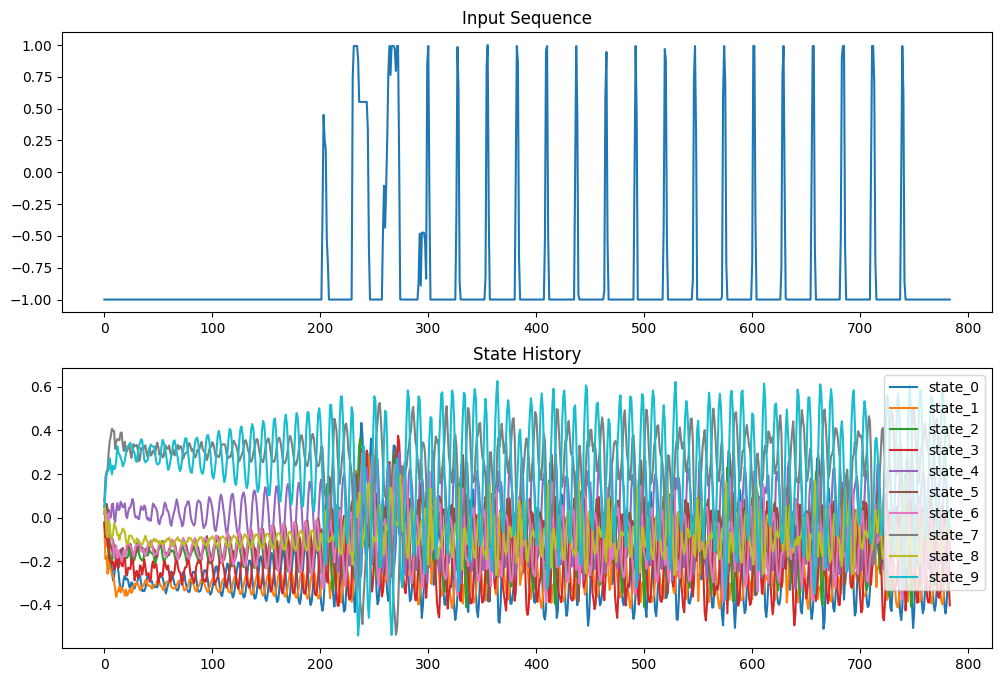

In [10]:
t = jnp.arange(784)

import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']

fig, axs = plt.subplots(2, 1, figsize=(1200*px, 800*px))
axs[0].plot(t, batch_x[0, :, 0])
axs[0].set_title('Input Sequence')
axs[1].plot(t, state_hist[0, :, 0:10], label=[f'state_{i}' for i in range(10)])
axs[1].set_title('State History')
axs[1].legend()
plt.show()

In [11]:
from flax.training import train_state
import optax


# def create_train_state(key, model_cls, lr):
#     '''
#     Create the training state for the model.
#     '''
#     model = model_cls(hidden_size=64, output_size=10)
#     init_x = jnp.ones((1, 784, 1))  # Example batch of inputs

#     params = model.init(key, init_x)['params']
#     print("Initialized parameter structure:", jax.tree_util.tree_map(jnp.shape, params))
#     # use adam 
#     optimizer = optax.sgd(learning_rate=lr, momentum=0.9)
#     return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [12]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
lr = 1e-2
# state = create_train_state(subkey, RNN, lr)
# print(state.params.keys())
# print(state.params['RNNCell_0'])
# print(state.params['Dense_0'])

In [13]:
# print(state.params)

In [14]:
# print(state.params['Dense_0']['kernel'].shape)
# print(state.params['Dense_0']['bias'].shape)
# print(train_state.params['output']['kernel'].shape)
# print(train_state.params['output']['bias'].shape)

In [15]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [16]:
def apply_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        logits, _ = state.apply_fn({'params': params}, images)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy
    

In [17]:
def run_epoch(state, train_dl, rng):
    """Train for a single epoch."""

    epoch_loss = []
    epoch_accuracy = []

    progress_bar = tqdm(train_dl, desc="Training", leave=True)
    batch_id = 0
    for batch_images, batch_labels in progress_bar:
        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
        # print(jnp.max(grads['dense_0']['kernel']), jnp.min(grads['dense_0']['kernel']))
        # print(loss)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
        batch_id += 1
        if batch_id % 3 == 0:
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item())
        
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy


In [18]:
def create_train_state(key, model_cls, lr):
    init_x = jnp.ones((128, 784, 1))  # Example batch of inputs

    model = model_cls(hidden_size=256, output_size=10)
    params = model.init(key, init_x)['params']
    
    # Debugging: Print parameter structure

    optimizer = optax.adam(lr)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )


In [19]:
state = create_train_state(key, BatchRNN, lr)

In [20]:
for epoch in range(30):
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    print(f"Epoch {epoch} | Loss: {train_loss} | Accuracy: {train_accuracy}")

Training:   2%|▏         | 10/469 [02:03<1:34:48, 12.39s/it, accuracy=0.109, loss=3.96]


KeyboardInterrupt: 